In [1]:
import torch
import numpy as np

import cupy as cp
from cucim.skimage import measure as cucim_measure

import time

def get_connected_components(img, connectivity=None):

    img_cupy = cp.asarray(img)
    labeled_img, num_features = cucim_measure.label(img_cupy, connectivity=connectivity, return_num=True)
    labeled_img_torch = torch.as_tensor(labeled_img, device=img.device)

    return labeled_img_torch, num_features

In [2]:
matrix1_numpy = np.zeros((10, 35, 35))
matrix1_numpy[0, 10:20, 10:20] = 1
matrix1_numpy[0, 25:28, 10:20] = 1
matrix1_numpy[0, 10:20, 21:30] = 1
matrix1_numpy[0, 5:7, 5:7] = 1

matrix2_numpy   = np.zeros((10, 35, 35))
matrix2_numpy[0, 10:20, 6:14] = 1
matrix2_numpy[0, 10:20, 15:24] = 1
matrix2_numpy[0, 25:28, 6:14] = 1
matrix2_numpy[0, 25:28, 15:24] = 1
matrix2_numpy[0, 25:27, 25:27] = 1

numpy_time = []
torch_time = []

start_time = time.time()
matrx1_cc_numpy, _ = get_connected_components(matrix1_numpy)
matrix2cc_numpy, _ = get_connected_components(matrix2_numpy)
end_time = time.time()
numpy_time.append(end_time - start_time)

device = torch.device('cuda:0')
matrix1_torch = torch.as_tensor(matrix1_numpy, dtype=torch.float32).to(device)
matrix2_torch = torch.as_tensor(matrix2_numpy, dtype=torch.float32).to(device)

start_time = time.time()
matrix1_cc_torch, _ = get_connected_components(matrix1_torch)
matrix2_cc_torch, _ = get_connected_components(matrix2_torch)
end_time = time.time()
torch_time.append(end_time - start_time)

print('Are the connected components equal?')
print('Matrix1:', np.allclose(matrx1_cc_numpy.cpu().numpy(), matrix1_cc_torch.cpu().numpy()))
print('Matrix2:', np.allclose(matrix2cc_numpy.cpu().numpy(), matrix2_cc_torch.cpu().numpy()))
print()
print('Time taken for numpy:', numpy_time)
print('Time taken for torch:', torch_time)

Are the connected components equal?
Matrix1: True
Matrix2: True

Time taken for numpy: [0.11384868621826172]
Time taken for torch: [0.0016086101531982422]


MY GPU: NVIDIA RTX A1000 Laptop GPU


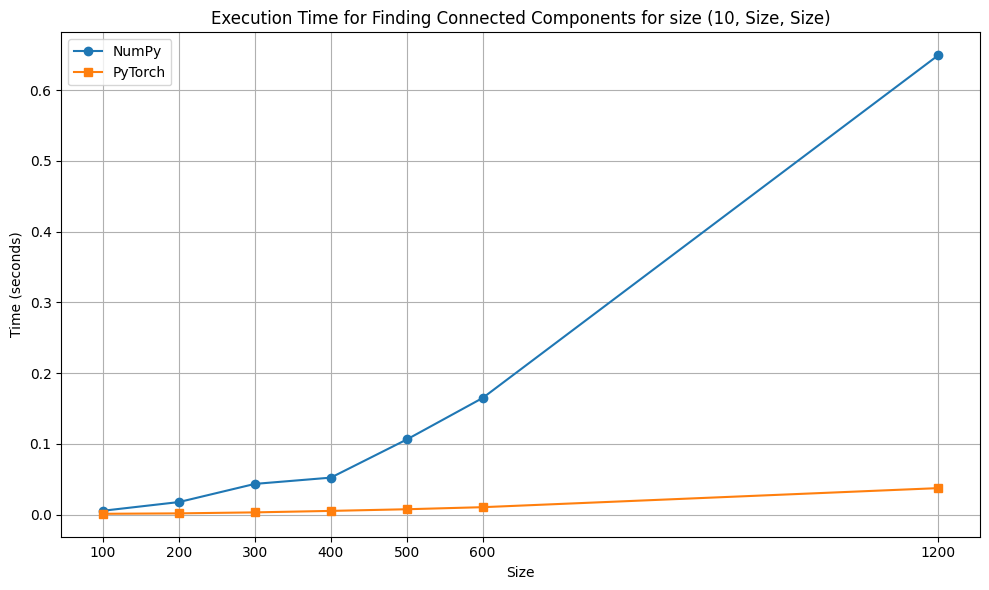

In [3]:
import matplotlib.pyplot as plt

# Initialize lists to store execution times
numpy_times = []
torch_times = []
matrix_sizes = [100, 200, 300, 400, 500, 600, 1200]  # Example matrix sizes to test

for size in matrix_sizes:
    # Generate random matrices of size (50, size, size)
    matrix1_numpy = np.zeros((50, size, size))
    matrix2_numpy = np.zeros((50, size, size))
    
    # Populate matrices with example patterns
    matrix1_numpy[0, size//4:size//2, size//4:size//2] = 1
    matrix1_numpy[0, size//2:size*3//4, size//4:size//2] = 1
    matrix1_numpy[0, size//4:size//2, size//2:size*3//4] = 1
    matrix1_numpy[0, size//8:size//6, size//8:size//6] = 1

    matrix2_numpy[0, size//4:size//2, size//8:size*2//8] = 1
    matrix2_numpy[0, size//4:size//2, size*3//8:size*3//4] = 1
    matrix2_numpy[0, size*3//4:size*3//4+3, size//8:size*2//8] = 1
    matrix2_numpy[0, size*3//4:size*3//4+3, size*3//8:size*3//4] = 1
    matrix2_numpy[0, size*3//4:size*3//4+2, size*7//8:size*7//8+2] = 1
    
    # NumPy calculation
    start_time = time.time()
    matrix1_cc_numpy, _ = get_connected_components(matrix1_numpy)
    matrix2_cc_numpy, _ = get_connected_components(matrix2_numpy)
    end_time = time.time()
    numpy_times.append(end_time - start_time)
    
    # PyTorch calculation
    device = torch.device('cuda:0')
    matrix1_torch = torch.as_tensor(matrix1_numpy, dtype=torch.float32).to(device)
    matrix2_torch = torch.as_tensor(matrix2_numpy, dtype=torch.float32).to(device)
    
    start_time = time.time()
    matrix1_cc_torch, _ = get_connected_components(matrix1_torch)
    matrix2_cc_torch, _ = get_connected_components(matrix2_torch)
    end_time = time.time()
    torch_times.append(end_time - start_time)


print('MY GPU: NVIDIA RTX A1000 Laptop GPU')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, numpy_times, marker='o', label='NumPy')
plt.plot(matrix_sizes, torch_times, marker='s', label='PyTorch')
plt.title('Execution Time for Finding Connected Components for size (10, Size, Size)')
plt.xlabel('Size')
plt.ylabel('Time (seconds)')
plt.xticks(matrix_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
